In [12]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import pandas as pd
from sklearn.metrics import f1_score, recall_score, accuracy_score
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
import matplotlib.pyplot as plt
import seaborn as sns
torch.manual_seed(99)

In [13]:
class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Linear(256*3*3, 10)

        nn.init.normal_(self.classifier.weight, 0, 0.01)
        nn.init.constant_(self.classifier.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [14]:
transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [15]:
fashion_mnist_train = datasets.FashionMNIST(root='./FashionMNIST', train=True, download=True, transform=transformations)
fashion_mnist_test = datasets.FashionMNIST(root='./FashionMNIST', train=False, download=True, transform=transformations)

In [16]:
batch_size = 64
train_loader = DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=False)

In [17]:
pretrained_model_cifar10 = torch.load('./models/cifar10_mini_vgg.pth', map_location=torch.device('cpu')) 
pretrained_model_mnist = torch.load('./models/cifar10_mini_vgg.pth', map_location=torch.device('cpu'))

In [18]:
print(pretrained_model_cifar10.keys())
print(pretrained_model_mnist.keys())

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'classifier.weight', 'classifier.bias'])
odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'classifier.weight', 'classifier.bias'])


In [19]:
model_cifar10 = MiniVGG().to('cpu')
model_mnist = MiniVGG().to('cpu')

model_cifar10.load_state_dict(pretrained_model_cifar10)
model_mnist.load_state_dict(pretrained_model_mnist)

<All keys matched successfully>

In [20]:
model_cifar10.features[2].state_dict()

OrderedDict([('weight',
              tensor([[[[-2.2723e-07, -4.1959e-07, -1.2874e-08],
                        [-5.3820e-08, -3.5285e-08,  1.3085e-10],
                        [-4.0859e-10, -7.4913e-12, -1.3883e-12]],
              
                       [[-5.5253e-06, -7.9452e-08, -8.7202e-10],
                        [-7.8819e-08,  5.3957e-22,  2.6144e-20],
                        [-4.1700e-11,  1.7307e-22,  1.1922e-22]],
              
                       [[-1.6071e-03, -1.6438e-03, -1.3335e-03],
                        [-1.4851e-03, -1.5397e-03, -1.1648e-03],
                        [-2.0745e-03, -1.9272e-03, -1.7380e-03]],
              
                       ...,
              
                       [[-4.4844e-03, -4.6813e-03, -5.7477e-03],
                        [-5.8775e-03, -6.2364e-03, -7.1206e-03],
                        [-5.7861e-03, -6.4992e-03, -7.6280e-03]],
              
                       [[ 9.7775e-11,  2.9410e-18, -2.4413e-16],
                        

In [21]:
for param in model_cifar10.features.parameters():
    param.requires_grad = False

for param in model_mnist.features.parameters():
    param.requires_grad = False

model_cifar10.classifier.requires_grad = True
model_mnist.classifier.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cifar10.parameters(), lr=0.001)
num_epochs = 5

def train(model, optimizer, criterion, train_loader, epochs=5):
    losses = []
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    plt.plot(losses)
    plt.show()

Epoch [1/5], Loss: 0.8064
Epoch [2/5], Loss: 0.1538
Epoch [3/5], Loss: 0.2695
Epoch [4/5], Loss: 0.2300
Epoch [5/5], Loss: 0.5269


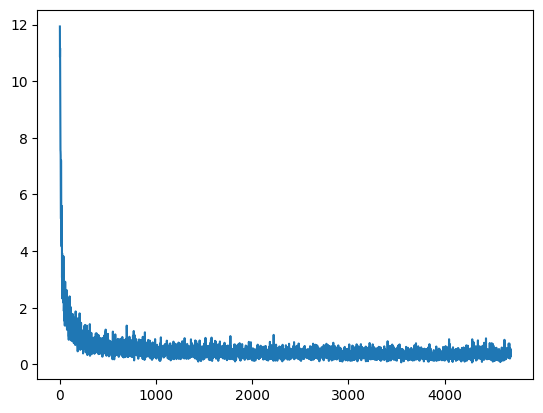

In [22]:
train(model_cifar10, optimizer, criterion, train_loader)

# Learning rate hơi cao nhưng thui không sao

Epoch [1/5], Loss: 9.3533
Epoch [2/5], Loss: 11.5599
Epoch [3/5], Loss: 11.0160
Epoch [4/5], Loss: 14.2572
Epoch [5/5], Loss: 10.4374


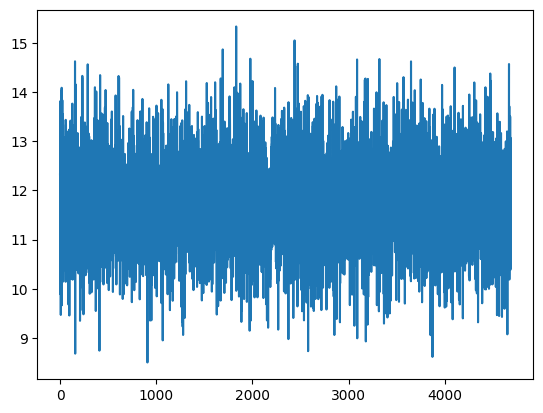

In [23]:
train(model_mnist, optimizer, criterion, train_loader)

Epoch [1/5], Loss: 2.3031
Epoch [2/5], Loss: 2.3018
Epoch [3/5], Loss: 2.3015
Epoch [4/5], Loss: 2.3041
Epoch [5/5], Loss: 2.3026


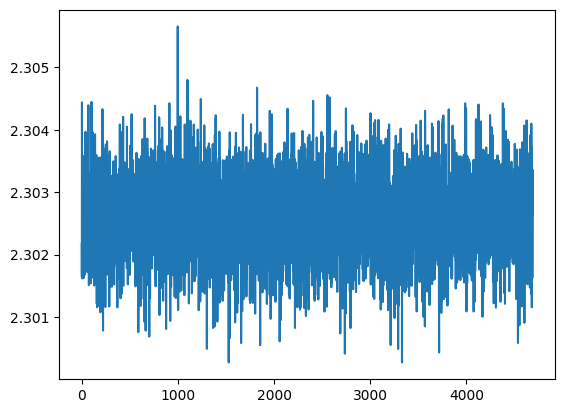

In [24]:
model_vgg = MiniVGG()

for param in model_vgg.features.parameters():
    param.requires_grad = True

model_vgg.classifier.requires_grad = True # require_grad không cần thiết nhưng cho rõ ràng là mình update toàn model

train(model_vgg, optimizer, criterion, train_loader)

In [32]:
model_vgg

MiniVGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=2304, out_features=10, bias=True)
)

In [38]:
train_nodes, eval_nodes = get_graph_node_names(model_vgg)

feature_extractor = create_feature_extractor(model_vgg, train_nodes)

for name, param in feature_extractor.named_parameters():
    print(f"Layer Name: {name}, Shape: {param.shape}")

Layer Name: features.0.weight, Shape: torch.Size([64, 1, 3, 3])
Layer Name: features.0.bias, Shape: torch.Size([64])
Layer Name: features.2.weight, Shape: torch.Size([64, 64, 3, 3])
Layer Name: features.2.bias, Shape: torch.Size([64])
Layer Name: features.5.weight, Shape: torch.Size([128, 64, 3, 3])
Layer Name: features.5.bias, Shape: torch.Size([128])
Layer Name: features.7.weight, Shape: torch.Size([128, 128, 3, 3])
Layer Name: features.7.bias, Shape: torch.Size([128])
Layer Name: features.10.weight, Shape: torch.Size([256, 128, 3, 3])
Layer Name: features.10.bias, Shape: torch.Size([256])
Layer Name: features.12.weight, Shape: torch.Size([256, 256, 3, 3])
Layer Name: features.12.bias, Shape: torch.Size([256])
Layer Name: classifier.weight, Shape: torch.Size([10, 2304])
Layer Name: classifier.bias, Shape: torch.Size([10])


In [ ]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Accuracy: {accuracy}')

In [ ]:
test(model_cifar10, test_loader)


Accuracy: 0.8747


In [ ]:
test(model_mnist, test_loader)


Accuracy: 0.0598


In [ ]:
test(model_vgg, test_loader)


Accuracy: 0.0997


In [ ]:
# save all the new finetuned models
torch.save(model_cifar10.state_dict(), './models/cifar10_mini_vgg_finetuned.pth')
torch.save(model_mnist.state_dict(), './models/mnist_mini_vgg_finetuned.pth')
torch.save(model_vgg.state_dict(), './models/vgg_mini_vgg_finetuned.pth')


<font size = "13"><span style="color:#EFE1D1">
ヽ(✿ﾟ▽ﾟ)ノ <br>
LEADERBOARD: 1. Finetuned CIFAR-10, 2. VGG scratch , 3. Finetuned MNIST

- Em nghĩ lí do Finetuned MNIST tệ vì nó được train để detect các số thay vì Finetuned CIFAR-10 được train detect các object. Cộng với việc mình freeze các layer features và chỉ chỉnh layer classifier
VGG train từ đầu thì không tốt bằng finetune cifar-10 model có lẽ vì số lần epoch quá nhỏ. <br>
- Em nghĩ khó có thể dự đoán performance sẽ như nào nếu train với nhiều epoch, khả năng VGG scratch sẽ bằng Finetuned CIFAR-10 nhưng MNIST sẽ khó achieve good performance hơn.

</span></font>